In [1]:
# Libraries
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cobra
from cobra.io import read_sbml_model

from efflux_method import *

### Preparation for modelling

In [2]:
# Configuration
model_path = "6_universal_mito_model.xml"
data_path = "S17305_modifiedReadCounts_mitomammal2.csv"

In [3]:
# Model
model = read_sbml_model(model_path)

# Gene list
gene_list = [g.id for g in model.genes]

# RNA-seq dict
dict_wt = read_csv_data(data_path, 0, 1, head=True, list_of_genes=gene_list, quantile=0.95)
dict_ko = read_csv_data(data_path, 0, 2, head=True, list_of_genes=gene_list, quantile=0.95)

### Preparation for analysis 

In [4]:
# Reaction of interest
tca_reactions = ['CSm', 'PDHm', 'ACONTm', 'ICDHyrm', 'AKGDm', 'SUCOASm', 'FUMm', 'MDHm']
etc_reactions = ['CI_mitoMap', 'CII_mitoMap', 'CIII_mitoMap', 'CIV_mitoMap', 'CV_mitoMap']
icit_reactions = ['r0913', 'r0917', 'r0917b_mitoMap']
cit_reactions = ['ACITLm_mitoMap', 'CITtamB']
akg_reactions = ['AKGMALtm', 'r0081', 'ORNTArm']
fum_reactions = ['FUMtmB_mitoMap']
succ_reactions = ['SUCCt2m', 'SUCCt3m_mitoMap', 'r0829', 'r0830', 'r0830B_mitoMap']

reaction_set = tca_reactions + etc_reactions + icit_reactions + cit_reactions + akg_reactions + fum_reactions + succ_reactions

In [5]:
# Helper function - create fluxes pandas dataframe 

def getFluxes(pfba_solution, reaction_set, model):
    
    # dataframe with all fluxes
    pfba_solution_df = pfba_solution.to_frame()
    names = [model.reactions.get_by_id(ID).name for ID in list(pfba_solution_df.index)]
    normalised_fluxes = [flux / pfba_solution.objective_value for flux in pfba_solution_df.fluxes]
    normalised_fluxes_1000 = [flux * 1000 for flux in normalised_fluxes]
    
    fluxes_df = pd.DataFrame({
        'name': names,
        'flux' : pfba_solution_df.fluxes,
        'normalisedFlux' : normalised_fluxes,
        'normalisedFlux*1000' : normalised_fluxes_1000
})

    # dataframe with only mATP-associated fluxes
    mATP_fluxes_df = fluxes_df.loc[fluxes_df.index.isin(reaction_set)]
        
    return fluxes_df, mATP_fluxes_df

In [6]:
# Plotting helper functions 

def getTopFluxes(df, top_n=30):
    df = df.copy()
    df['normalisedFlux'] = df['normalisedFlux'].abs()
    return df.sort_values(by='normalisedFlux', ascending=False).head(top_n)

def getColor(reaction_id):
    if reaction_id in tca_reactions:
        return '#fa8e64'  # TCA cycle
    elif reaction_id in etc_reactions:
        return '#64c3a3'  # ETC
    else:
        return 'gray'     # Other

def plotFluxes(ax, fluxes_df, title):
    colors = [getColor(rid) for rid in fluxes_df.index]
    ax.barh(fluxes_df.index, fluxes_df['normalisedFlux'], height=0.5, color=colors)
    ax.legend(handles=[tca_patch, etc_patch, other_patch], fontsize=16)
    ax.tick_params(axis="y", labelsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.set_title(title, size=24)

# Legend patches
tca_patch = mpatches.Patch(color='#fa8e64', label='TCA cycle')
etc_patch = mpatches.Patch(color='#64c3a3', label='ETC')
other_patch = mpatches.Patch(color='gray', label='Other')

# Modeling 3w WT cells

### Run FBA 

In [7]:
# Eflux (constraints)
Eflux(model, dict_wt, 1000, 1, ignore_human=True)

# Run FBA
fba_solution_wt = model.optimize()

# fba solution
#model.metabolites.atp_m.summary(solution = fba_solution_wt)

In [8]:
pfba_solution_wt = cobra.flux_analysis.pfba(model)

# pFBA solution
#model.metabolites.atp_m.summary(solution = pfba_solution_wt)

### Run pFBA

# Modeling 3w KO cells 

### Run FBA

In [9]:
# Eflux (constraints)
Eflux(model, dict_ko, 1000, 1, ignore_human=True)

# Run FBA
fba_solution_ko = model.optimize()

# fba solution
#model.metabolites.atp_m.summary(solution = fba_solution_ko)

### Run pFBA

In [10]:
pfba_solution_ko = cobra.flux_analysis.pfba(model)

# pFBA solution
#model.metabolites.atp_m.summary(solution = pfba_solution_ko)

# WT / KO COMPARISON 

In [11]:
# Get data
all_fluxes_wt = getFluxes(pfba_solution_wt, reaction_set, model)[0]
all_fluxes_ko = getFluxes(pfba_solution_ko, reaction_set, model)[0]

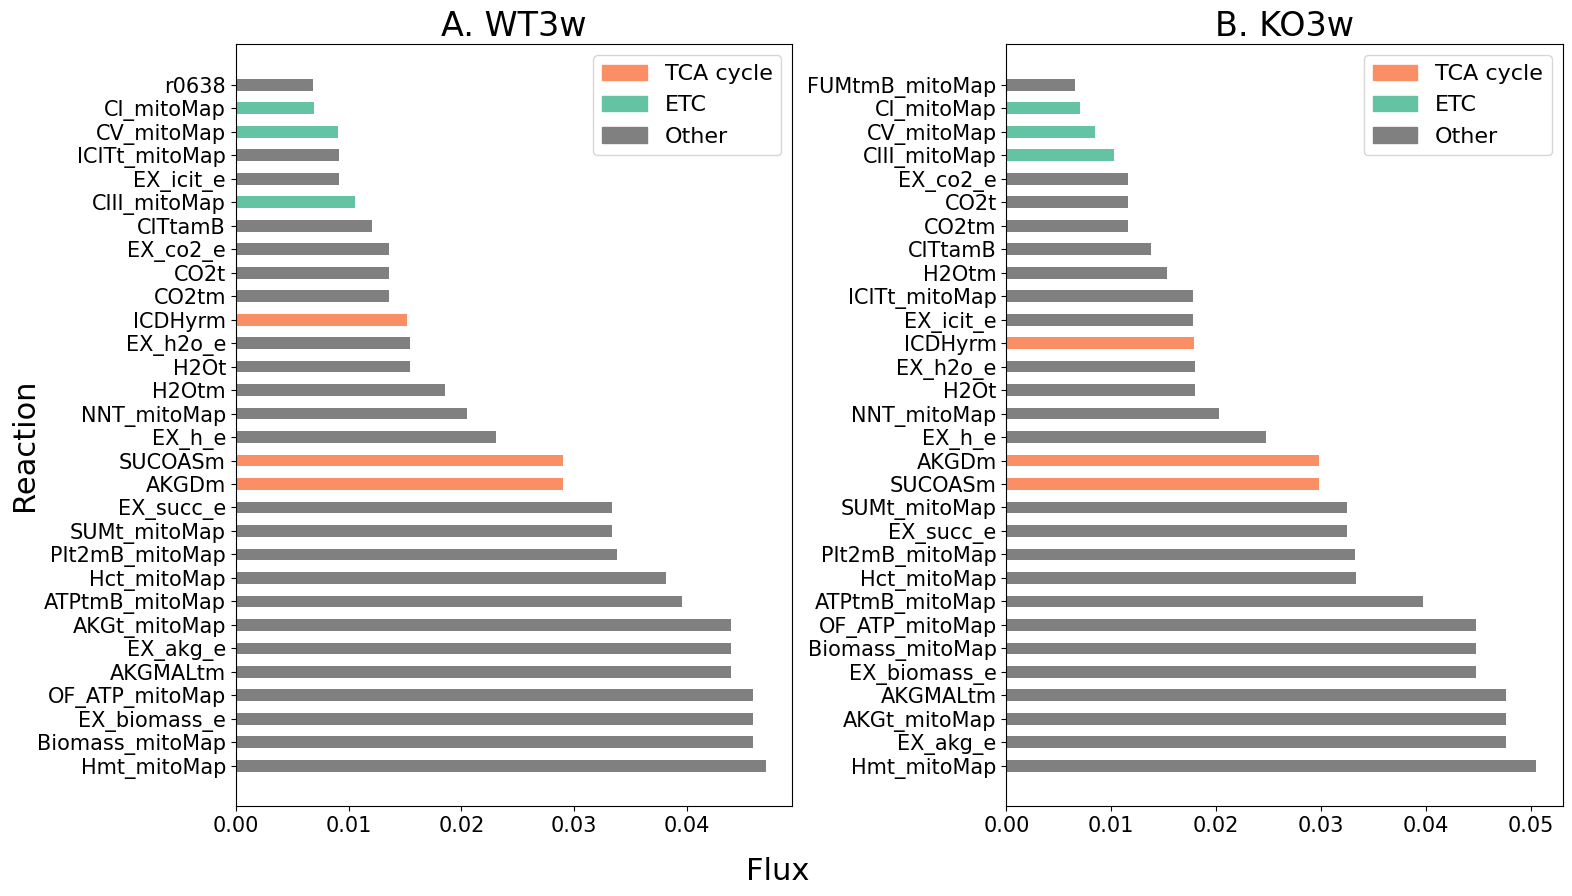

In [12]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
fig.subplots_adjust(wspace=0.3)

plotFluxes(ax1, getTopFluxes(all_fluxes_wt), "A. WT3w")
plotFluxes(ax2, getTopFluxes(all_fluxes_ko), "B. KO3w")

fig.supxlabel('Flux', size=22)
fig.supylabel('Reaction', size=22)

plt.tight_layout()
plt.savefig('mitomammalfluxesTOUT.pdf', dpi=320)

# Visualisation 

In [13]:
import sammi
import re 

class Metabolic_viz:
    def __init__(self,model,fluxes,names):
        self.model = model
        self.fluxes = fluxes
        self.names = names
        self.datasets = {}
        self.reaction_list = {}
        self.selected_fluxes = []
        self.parser = [] # init the parser

    def select_metabolites(self,met):
        list_of_reactions = []
        for i in met:
            regex = re.compile(f"^{i}_.", flags=re.IGNORECASE)
            for model_met in self.model.metabolites.query(regex,attribute='id'):
                for reaction in model_met.reactions:
                    list_of_reactions.append(reaction.id)
            self.reaction_list[i] = list(set(list_of_reactions))

    def find_all_subsystem(self):
        for rxn in self.model.reactions:
            if 'notes' in rxn.__dict__.keys():
                if 'SUBSYSTEM' in rxn.__dict__['notes'].keys():
                    if rxn.__dict__['notes']['SUBSYSTEM'] not in self.reaction_list.keys():
                        self.reaction_list[rxn.__dict__['notes']['SUBSYSTEM']] = []
                    self.reaction_list[rxn.__dict__['notes']['SUBSYSTEM']].append(rxn.id)
                    

    def make_viz(self):
        self.selected_fluxes = []
        mask=[]
        for key,val in self.reaction_list.items():
            self.parser.append(sammi.parser(key,val))
            mask = mask + val
        self.mask = mask
        for flx in self.fluxes:
            self.selected_fluxes.append(np.array(list(map(int,flx[mask]))))
        self.dataset=[sammi.data('reactions',
                                 'size',
                                 np.vstack(self.selected_fluxes).T,
                                 mask,
                                 self.names),
                     sammi.data('reactions',
                                 'color',
                                 np.vstack(self.selected_fluxes).T,
                                 mask,
                                 self.names),
                     sammi.data('links',
                                 'size',
                                 np.vstack(self.selected_fluxes).T,
                                 mask,
                                 self.names)]
        self.secondaries = secondaries = ['^h_.$','^h2o_.$','^atp_.$','^adp_.','^pi_.','^o2_.','^co2_.','^nad_.','^nadh_.','^ndap_.','^PMF_.','^ndaph_.']
        sammi.plot(self.model,self.parser,datat = self.dataset,secondaries = self.secondaries,)

In [14]:
visu = Metabolic_viz(model.copy(), 
                     [pfba_solution_wt.fluxes, pfba_solution_ko.fluxes], 
                     ["wt", "ko"])

In [15]:
visu.find_all_subsystem()
visu.select_metabolites(["atp"])
#visu.make_viz()

# Exports


In [16]:
# pFBA fluxes WT
pd.DataFrame.to_csv(getFluxes(pfba_solution_wt, reaction_set, model)[0], 'all_pFBA_fluxes_wt.csv')
pd.DataFrame.to_csv(getFluxes(pfba_solution_wt, reaction_set, model)[1], 'mATP_pFBA_fluxes_wt.csv')

# pFBA fluxes KO 
pd.DataFrame.to_csv(getFluxes(pfba_solution_ko, reaction_set, model)[0], 'all_pFBA_fluxes_ko.csv')
pd.DataFrame.to_csv(getFluxes(pfba_solution_ko, reaction_set, model)[1], 'mATP_pFBA_fluxes_ko.csv')